# Implementation of the MINA model

The model is implemented based on:
* J Moysan, A Apfel, G Corneloup, B Chassignole, Modelling the grain orientation of austenitic stainless steel multipass welds to improve ultrasonic assessment of structural integrity, International Journal of Pressure Vessels and Piping, Volume 80, Issue 2, 2003, Pages 77-85, ISSN 0308-0161, https://doi.org/10.1016/S0308-0161(03)00024-3.
* Cécile Gueudre, Loïc Le Marrec, Joseph Moysan, Bertrand Chassignole, Direct model optimisation for data inversion. Application to ultrasonic characterisation of heterogeneous welds, NDT & E International, Volume 42, Issue 1, 2009, Pages 47-55, ISSN 0963-8695, https://doi.org/10.1016/j.ndteint.2008.07.003.

_Acknowledgements:_
Some advantage was taken from the MATLAB implementation by David Fan (28/09/2010 at Imperial College London).

# First test case 
### (do not change the parameters until well fixed or make a note)
---
D717A from Moysan et al. (2003) - parameters for modelling in Table 2 in the paper.
* Order of passes: [1...m]
* $R_L$: 0.47
* $R_V$: 0.26
* $\theta_B$: 18
* $\theta_C$: 12
* number of layers: 11
* number of passes (see Fig. 2(b)): 1, 2, 2, 2, 2, 3, 3, 4, 4, 4, 4
* electrode diameter (per layer): 1.6, 2.5, 3.2, 4, 5, 5, 5, 5, 4, 4, 4
* $a = 38$ mm
* $b = 4$ mm

* $c = 36$ mm

In [84]:
import operator
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook

In [73]:
def recast_features(features_per_layer, passes_layout):
    """
    Takes properties defined per layer and the array describing number of passes per layer
    and creates a new array with properties per pass
    
    Parameters:
    ---
    features_per_layer: ndarray, array defining a property ler layer, e.g. thicknes per layer
    passes_layout: ndarray, layout of passes, i.e. how many passes belong to each layer
    
    Returns:
    ---
    recast: ndarray, array with properties defined per each pass
    """
    nested = [counter*[feature] for counter, feature in zip(passes_layout, features_per_layer)]
    recast = np.array([item for sublist in nested for item in sublist])
    return recast

class MINA_weld(object):
    """
    MINA model object collecting parameters of a weld and enabling to calculate and visualise grain orientations.
    
    On initialisation, one should set up weld parameters:
    ---
    remelt_h: horizontal remelting rate
    remelt_v: vertical remelting rate
    theta_b: incline angle (resulting from the electrode tilt) for grains leaning on the chamfer
    theta_c: incline angle (resulting from the electrode tilt) for grains leaning on another pass
    order: order of passes - 'left_to_right': [1...m], 'right_to_left': [m...1], 'mixed': [1,3,...,m,...,4,2]
    number_of_layers: self explanatory
    number_of_passes: number of passes per layer
    electrode_diameter: electrod diameter for each layer
    a: thickness
    b: weld base
    c: length of the top surface
    h_top: thickness of top part of the last layer of passes (here, set to 0)
    """
    def __init__(self, weld_parameters, **kwargs):
        for parameter, value in weld_parameters.items():
            setattr(self, parameter, value)
        for key, value in kwargs:
            setattr(self, key, value)
        self.h_top = 0
        # check if all parameters are there
        try:
            print('------MINA model setup------')
            print('Horizontal remelting rate: {}'.format(self.remelt_h))
            print('Vertical remelting rate: {}'.format(self.remelt_v))
            print('theta_b and theta_c: {} and {}'.format(self.theta_b, self.theta_c))
            print('Order of passes: {}'.format(self.order))
            print('Number of layers: {}'.format(self.number_of_layers))
            print('Number of passes: {}'.format(self.number_of_passes))
            print('Electrode diameter: {}'.format(self.electrode_diameter))
            print('Weld thickness: {}'.format(self.a))
            print('Chamfer base: {}'.format(self.b))
            print('Chamfer top: {}'.format(self.c))
            print('----------------------------')
        except AttributeError:
            print("MINA parameters corrupt. Please redefine the model.")

#     remelt_h = property(operator.attrgetter('_remelt_h'))
#     @remelt_h.setter
#     def remelt_h(self, value):
#         if not (0 < value < 1): raise Exception("remelt_h parameter should be within the (0, 1) range") 
#         self._remelt_h = value
#     remelt_v = property(operator.attrgetter('_remelt_v'))
#     @remelt_v.setter
#     def remelt_v(self, value):
#         if not (0 < value < 1): raise Exception("remelt_v parameter should be within the (0, 1) range") 
#         self._remelt_v = value
#     theta_b = property(operator.attrgetter('_theta_b'))
#     @theta_b.setter
#     def theta_b(self, value):
#         if not (0 < value): raise Exception("theta_b parameter should be within the (0, 1) range") 
#         self._theta_b = value
#     theta_c = property(operator.attrgetter('_theta_c'))
#     @theta_c.setter
#     def theta_c(self, value):
#         if not (0 < value): raise Exception("theta_c parameter should be within the (0, 1) range") 
#         self._theta_c = value
#     order = property(operator.attrgetter('_order'))
#     @order.setter
#     def order(self, value):
#         if not (value=='left_to_right' or value == 'right_to_left' or value == 'mixed'): 
#             raise Exception("order parameter should be 'left_to_right', 'right_to_left', or 'mixed'") 
#         self._order = value
#     number_of_layers = property(operator.attrgetter('_theta_b'))
#     @number_of_layers.setter
#     def theta_b(self, value):
#         if not (0 < value): raise Exception("theta_b parameter should be within the (0, 1) range") 
#         self._theta_b = value

        
    
    def define_grid_size(self, size):
        """
        Defines the size of the grid for the MINA model.
        
        Parameters:
        ---
        size: int, grid size in milimetres
        """
        self.grid_size = size
        elements_x = int(np.ceil(self.c/self.grid_size))
        elements_y = int(np.ceil(self.a/self.grid_size))
        seeds_x = self.grid_size/2 + np.arange(0, elements_x*self.grid_size, self.grid_size)
        seeds_y = self.grid_size/2 + np.arange(0, elements_y*self.grid_size, self.grid_size)
        self.xx, self.yy = np.meshgrid(seeds_x, seeds_y)
        self.xx += -self.c/2
    
    def get_chamfer_profile(self, y):
        """
        Outputs the profile of the weld chamfer (a simple mapping from the horizontal coordinate(y)
        to the vertical coordinate(z). Used for checking whether a certain point is inside the weld or not.
        
        Parameters:
        ---
        y: float, horizontal coordinate)
        """
        boundary_gradient = 2*self.a/(self.c - self.b)
        f = boundary_gradient*(abs(y) - self.b/2)
        f *= (f >= 0)
        return f
    
    def calculate_passes(self):
        """
        Calculates subsequent weld passes, their locations, dimensions, and characteristic points.
        """
        # calculate layer thicknesses and pass widths
        beta = (self.a - self.h_top)/((1 - self.remelt_v)*self.electrode_diameter.sum()\
                                      + self.remelt_v*self.electrode_diameter[-1])
        self.layer_thickness = beta*self.electrode_diameter
        
        self.pass_width = (self.b + (self.c - self.b)/
                      self.a*(beta*((1 - self.remelt_v)*np.cumsum(self.electrode_diameter)
                                    + self.remelt_v*self.electrode_diameter)))/\
                        (self.number_of_passes*(1 - self.remelt_h) + self.remelt_h)
        
        layer_width = self.pass_width*((1 - self.remelt_h)*self.number_of_passes + 
                                  self.remelt_h)

        # Calculate centres of each pass
        pass_y_abscissa = np.cumsum(self.layer_thickness*np.array([1] + 
                                                             [1 - self.remelt_v]*(len(self.layer_thickness) - 1)))
        pass_x_ordinates = np.cumsum(self.pass_width.reshape(-1, 1)*\
                                     np.array([0.5] + 
                                              [1 - self.remelt_h]*self.number_of_passes.max()).reshape(1, -1), 
                                    axis=1)
        # Assemble arrays of pass centre coordinates
        # and calculate orientation angle corrections based on electrode tilt
        pass_x_centers = []
        pass_y_centers = []
        passes_in_layer = dict()
        pass_counter = 0
        self.pass_corrections = []
        for i, passes in enumerate(list(self.number_of_passes)):
            passes_in_layer.update({i: (list(range(pass_counter, pass_counter + passes)))})
            this_pass_corrections = (int(passes) > 1)*[-self.theta_b] + \
                                    [-self.theta_c]*(int(passes) - 2)*(int(passes) > 2) + [0]
            self.pass_corrections.extend(this_pass_corrections)
            pass_counter += passes
            pass_y_centers.extend([pass_y_abscissa[i]]*passes)
            pass_x_centers.extend(list(pass_x_ordinates[i, :passes] - layer_width[i]/2))

        # Construct a look-up dictionary telling which pass belongs to which layer
        self.layer_of_pass = dict()
        for k, v in passes_in_layer.items():
            for this_pass in v:
                if this_pass not in self.layer_of_pass.keys():
                    self.layer_of_pass.update({this_pass: k})

        # Construct characteristic points for passes, refer to Moysan (2003)
        self.point_b = np.c_[np.array(pass_x_centers), np.array(pass_y_centers)]
        self.point_o = np.copy(self.point_b)
        self.point_o[:, 1] += -recast_features(self.layer_thickness, self.number_of_passes)
        self.point_c = self.point_b + np.array([[0, self.h_top]])
        self.point_d = np.copy(self.point_b)
        self.point_d[:, 1] +=  recast_features(self.pass_width, self.number_of_passes)/2
        
    def bottom_parabola(self, x, pass_no):
        """
        Returns the parabola surrounding a given pass from the bottom for given x ordinates.
        
        Paramteres:
        ---
        x: ndarray, ordinate
        pass_no: int, which pass is of interest
        
        Returns:
        ---
        parabola: ndarray, y values for the parabola
        """
        parabola = self.layer_thickness[self.layer_of_pass[pass_no]]/\
                    (self.pass_width[self.layer_of_pass[pass_no]]/2)**2*\
                    (x - self.point_o[pass_no, 0])**2 + self.point_o[pass_no, 1]
        return parabola

    def top_parabola(self, x, pass_no):
        """
        Returns the parabola surrounding a given pass from the top for given x ordinates.
        
        Paramteres:
        ---
        x: ndarray, ordinate
        pass_no: int, which pass is of interest
        
        Returns:
        ---
        parabola: ndarray, y values for the parabola
        """
        parabola = -self.h_top/(self.pass_width[self.layer_of_pass[pass_no]]/2)**2*\
                    (x - self.point_c[pass_no, 0])**2 + self.point_c[pass_no, 1]
        return parabola
    def calculate_thermal_gradients(self):
        """
        Calculates thermal gradients over the defined grid basd on the location of grid centroids.
        """
#         pass_assignments = -99 + np.zeros(xx.shape)
        # Prefedine array of thermal gradients with NaNs
        self.alpha_g = np.nan*np.zeros(self.xx.shape)
        for this_pass in range(len(self.point_c)):
            points_in = (np.where((self.yy > self.bottom_parabola(self.xx, this_pass)) & 
                                  (self.yy < self.top_parabola(self.xx, this_pass))))
#             pass_assignments[points_in[0], points_in[1]] = this_pass
            self.alpha_g[points_in[0], points_in[1]] = np.arctan((self.xx[points_in[0], points_in[1]] -
                                                                  self.point_d[this_pass, 0])/\
                                                                (self.point_d[this_pass, 1] - 
                                                                 self.yy[points_in[0], points_in[1]])) + \
                                                                self.pass_corrections[this_pass]
    def calculate_grain_orientation(self, n=10):
        """
        Calculates final grain orientations accounting for the effect of the temperature
        gradient, epitaxial growth and selective growth.
        
        Parameters:
        ---
        n: int, how many iterations are allowed for the epitaxial/selective grwoth loop
        """
        # Put NaNs to points not belonging to the weld.
        self.xx[self.yy < self.get_chamfer_profile(self.xx)] = np.nan
        self.yy[self.yy < self.get_chamfer_profile(self.xx)] = np.nan

        # Find elements belonging to the weld in the lowest layer
        in_weld = np.where(~np.isnan(self.xx[0, :]))[0]
        # Copy thermal gradients to grain orientations
        self.grain_orientations = np.copy(self.alpha_g)
        for i in range(1, self.grain_orientations.shape[1] + 1):
            new_starters = np.where(np.isnan(self.grain_orientations[i - 1, :]))[0]
            old_grains = np.where(~np.isnan(self.grain_orientations[i - 1, :]))[0]
            self.grain_orientations[i, new_starters]= self.alpha_g[i, new_starters]
            previous_alpha = self.grain_orientations[i - 1, old_grains]
            for iteration in range(n):
                angle_difference = previous_alpha - self.alpha_g[i, old_grains]
                t = np.cos(angle_difference)
                t[angle_difference >= np.pi/2] = 0
                this_alpha = t*previous_alpha + (1 - t)*self.alpha_g[i, old_grains]
                previous_alpha = this_alpha
            self.grain_orientations[i, old_grains] = np.copy(this_alpha)
    
    def plot_passes(self, points=False):
        """
        Plots passes layout.
        
        Parameters:
        ---
        points: boolean, if True, plots also the characteristic points of passes (see Moysan, 2003)
        """
        fig, ax = plt.subplots()
        for i in range(len(self.point_b)):
            local_x = np.linspace(self.point_b[i, 0] - 
                                  self.pass_width[self.layer_of_pass[i]]/2, 
                                  self.point_b[i, 0] + 
                                  self.pass_width[self.layer_of_pass[i]]/2, 100)
            y_top = self.top_parabola(local_x, i)
            y_bot = self.bottom_parabola(local_x, i)
            ax.fill_between(local_x, y_bot, y_top, alpha=0.8)
            ax.set_aspect('equal')
            if points:
                ax.plot(self.point_b[i, 0], self.point_b[i, 1], 'o',ms=4, c='black')
                ax.plot(self.point_o[i, 0], self.point_o[i, 1], '^',ms=4, c='black')
            ax.plot([-self.b/2, -self.c/2], [0, self.a], lw=0.5, c='gray')
            ax.plot([self.b/2, self.c/2], [0, self.a], lw=0.5, c='gray')
            ax.plot([-1.2*self.c/2, 1.2*self.c/2], [0, 0], lw=0.5, c='gray')
            ax.plot([-1.2*self.c/2, 1.2*self.c/2], [self.a, self.a], lw=0.5, c='gray')
        ax.set_xlabel(r'$y$ in mm')
        ax.set_ylabel(r'$z$ in mm')

    def plot_grain_orientations(self):
        """
        Plots both thermal gradients and final grain orientations.
        """
        fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(8, 4))
        ax1.quiver(self.xx, self.yy, np.cos(self.alpha_g + np.pi/2), 
                   np.sin(self.alpha_g + np.pi/2), units='xy', scale=0.5)
        ax1.set_aspect('equal')
        ax1.set_title('local temperature gradients')
        ax1.plot([-self.b/2, -self.c/2], [0, self.a], lw=0.5, c='gray')
        ax1.plot([self.b/2, self.c/2], [0, self.a], lw=0.5, c='gray')
        ax1.plot([-1.2*self.c/2, 1.2*self.c/2], [0, 0], lw=0.5, c='gray')
        ax1.plot([-1.2*self.c/2, 1.2*self.c/2], [self.a, self.a], lw=0.5, c='gray')
        ax1.set_xlabel(r'$y$ in mm')
        ax1.set_ylabel(r'$z$ in mm')

        ax2.quiver(self.xx, self.yy, np.cos(self.grain_orientations + np.pi/2), 
                   np.sin(self.grain_orientations + np.pi/2), units='xy', scale=0.5)
        ax2.set_aspect('equal')
        ax2.set_title('final grain orientations')
        ax2.plot([-self.b/2, -self.c/2], [0, self.a], lw=0.5, c='gray')
        ax2.plot([self.b/2, self.c/2], [0, self.a], lw=0.5, c='gray')
        ax2.plot([-1.2*self.c/2, 1.2*self.c/2], [0, 0], lw=0.5, c='gray')
        ax2.plot([-1.2*self.c/2, 1.2*self.c/2], [self.a, self.a], lw=0.5, c='gray')
        ax2.set_xlabel(r'$y$ in mm')
        plt.tight_layout()


        

In [80]:
weld_parameters = dict([('remelt_h', 0.47),
                        ('remelt_v', 0.26),
                        ('theta_b', np.deg2rad(18)),
                        ('theta_c', np.deg2rad(12)),
                        ('order', 'left_to_right'),
                        ('number_of_layers', 11),
                        ('number_of_passes', np.array([1] + 4*[2] + 2*[3] + 4*[4])),
                        ('electrode_diameter', np.array([1.6] + [2.5] + [3.2] + [4] + [5]*4 + [4]*3)),
                        ('a', 38),
                        ('b', 4),
                        ('c', 36)])
weld = MINA_weld(weld_parameters)
# weld.h_top = 0

------MINA model setup------
Horizontal remelting rate: 0.47
Vertical remelting rate: 0.26
theta_b and theta_c: 0.3141592653589793 and 0.20943951023931956
Order of passes: left_to_right
Number of layers: 11
Number of passes: [1 2 2 2 2 3 3 4 4 4 4]
Electrode diameter: [ 1.6  2.5  3.2  4.   5.   5.   5.   5.   4.   4.   4. ]
Weld thickness: 38
Chamfer base: 4
Chamfer top: 36
----------------------------


In [81]:
weld.define_grid_size(2)
weld.calculate_passes()
weld.calculate_thermal_gradients()
weld.calculate_grain_orientation()

/home/michal/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:122: RuntimeWarning: invalid value encountered in greater_equal
/home/michal/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:235: RuntimeWarning: invalid value encountered in less


<IPython.core.display.Javascript object>


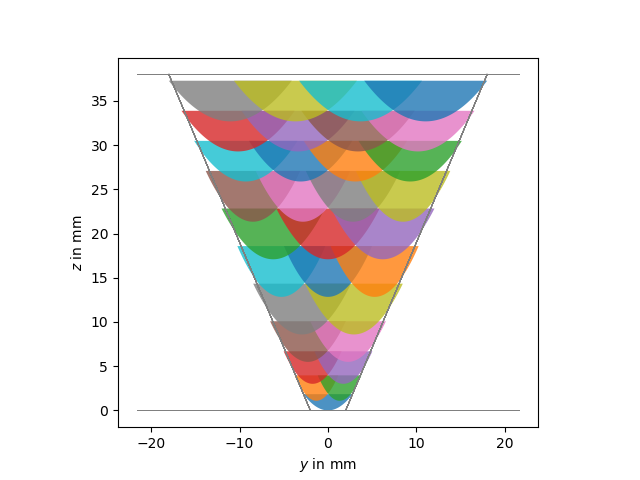

In [82]:
weld.plot_passes()

<IPython.core.display.Javascript object>


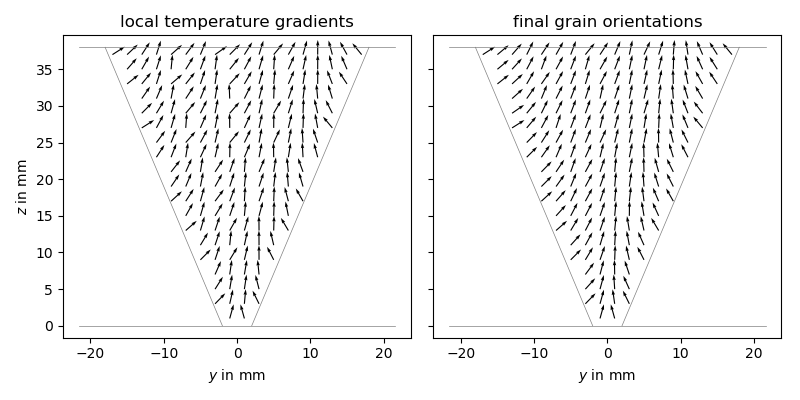

In [83]:
weld.plot_grain_orientations()